# Quant Trading and Price Impact Coursework

### Group Member: Dean Yang, Alek Dimitrov, Mingyuan Xia

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)

### Key parameters

In [2]:
h = 1
required_corr = 0.1

### 2.1 Data Processing

In [3]:
# Read in the data and concatenate them
flist = []
bin_sample_path = 'binSamples'
for month_int in range(1,13):
    month = '%02d' % month_int
    filename = f'{bin_sample_path}/bin2019{month}.csv'
    flist.append(pd.read_csv(filename))

stock_info_df = pd.concat(flist, axis = 0, ignore_index = False)    


In [4]:
stock_info_df

,date,time,stock,trade,orderFlow,hidden,auction,mid,midEnd,spread,effSpread,lobImb,effLobImb,trdLiq,ofLiq,depth,nbEvents,nbHidden,nbTrades
0,2019-01-02,09:30:10,A,0,1300,100,0,66.215,66.220,0.285,NaN,-0.333333,NaN,0,1300,300.0000,2,1,0
1,2019-01-02,09:30:20,A,0,-300,100,0,66.335,66.335,0.145,NaN,0.333333,NaN,0,300,350.0000,2,1,0
2,2019-01-02,09:30:30,A,0,200,0,0,66.335,66.335,0.145,NaN,0.000000,NaN,0,200,600.0000,1,0,0
3,2019-01-02,09:30:40,A,0,300,0,0,66.340,66.340,0.140,NaN,0.200000,NaN,0,300,500.0000,2,0,0
4,2019-01-02,09:31:00,A,0,0,100,0,66.270,66.270,0.070,NaN,0.500000,NaN,0,400,375.0000,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858335,2019-12-27,15:59:10,ARE,0,96,0,0,160.360,160.355,0.020,NaN,0.869159,NaN,0,358,84.0000,4,0,0
1858336,2019-12-27,15:59:20,ARE,12,-186,0,0,160.360,160.360,0.020,0.0300,0.754386,0.082569,12,516,137.6000,5,0,1
1858337,2019-12-27,15:59:30,ARE,0,-813,0,0,160.365,160.355,0.025,0.0275,0.980198,-0.389860,200,4659,171.1667,6,0,2
1858338,2019-12-27,15:59:40,ARE,35,0,110,0,160.360,160.390,0.020,0.0200,0.000000,0.582989,59,1618,252.7143,7,1,2


In [5]:
# report the volatility and volume calculations over dataframe containing all 12 months
# fill missing volumes with 0
traded_volume_df = stock_info_df[['stock', 'date','trade','time']].pivot(index= ['stock','date'], 
                                                                    columns = ['time'])['trade'].fillna(0).astype(int)
# fill propagates last valid value forwards
px_df = stock_info_df[['stock', 'date','midEnd','time']].pivot(index= ['stock','date'], 
                columns = ['time'])['midEnd'].fillna(method='ffill', axis = 'columns').fillna(method='bfill', axis = 'columns')

In [6]:
traded_volume_temp = traded_volume_df.reset_index()
traded_volume_temp['month'] = traded_volume_temp.date.str.slice(5,7).astype(int)

# stock list 
stock_list = traded_volume_temp['stock'].values
stock_list = np.unique(stock_list)


"""
month_trade_list = []

# create a list of dataframes, each containing the traded volume data for a month
for i in range(1,13):
    month_data = traded_volume_temp[traded_volume_temp.month == i].drop(columns = 'month')
    month_trade_list.append(month_data.set_index(['stock','date']))
"""


"\nmonth_trade_list = []\n\n# create a list of dataframes, each containing the traded volume data for a month\nfor i in range(1,13):\n    month_data = traded_volume_temp[traded_volume_temp.month == i].drop(columns = 'month')\n    month_trade_list.append(month_data.set_index(['stock','date']))\n"

In [7]:
# compute the price return volatility as a standard-deviation row-wise
# compute the total daily traded volume as the sum of all volumes in either direction using abs().sum over rows (axis columns)

daily_stock_info_df = pd.DataFrame({
    'px_vol' : px_df.pct_change(1,axis = 'columns').std(axis = 'columns'),
    'volume': traded_volume_df.abs().sum(axis = 'columns'),
}).reset_index()

In [8]:
daily_stock_info_df

,stock,date,px_vol,volume
0,A,2019-01-02,0.000383,217804
1,A,2019-01-03,0.000527,485020
2,A,2019-01-04,0.000366,244093
3,A,2019-01-07,0.000359,251175
4,A,2019-01-08,0.000364,181329
...,...,...,...,...
12397,ARE,2019-12-20,0.000225,57796
12398,ARE,2019-12-23,0.000112,45866
12399,ARE,2019-12-24,0.000135,17555
12400,ARE,2019-12-26,0.000138,24736


In [82]:
num_days_precompute = 20
#computing rolling means over both columns separately at once by stacking them with another pivot
stacked_info = daily_stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(0)


# Note this does not allow for alternative decay kernels, such as normalising or power-law

monthly_stock_info_df = pd.DataFrame({
    "px_vol": stacked_info.px_vol.unstack(),
    "volume": stacked_info.volume.unstack(),
}).reset_index()
# stacked_info was the dataframe with 20-day rolling averages of price volatility and daily traded volume




In [84]:
stacked_info

px_vol                                                    \
stock              A       AAL       AAP      AAPL      ABBV       ABC   
date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2019-12-20  0.000208  0.000286  0.000288  0.000165  0.000227  0.000288   
2019-12-23  0.000206  0.000286  0.000285  0.000163  0.000225  0.000285   
2019-12-24  0.000201  0.000283  0.000285  0.000162  0.000217  0.000286   
2019-12-26  0.000180  0.000282  0.000278  0.000160  0.000214  0.000268   
2019-12-27  0.000176  0.000286  0.000275  0.000164  0.000214  0.000263   

                                                    ...    volume             \
stock           ABMD       ABT       ACN      ADBE  ...      ANSS       ANTM   
date                                                ...                        
2019-01-02       NaN       NaN       NaN       NaN  ...       NaN        NaN   
2019-01-03       NaN       NaN       NaN       NaN  ...       NaN        NaN   
2019-01-04       NaN       NaN       NaN       NaN  ...       NaN        NaN   
2019-01-07       NaN       NaN       NaN       NaN  ...       NaN        NaN   
2019-01-08       NaN       NaN       NaN       NaN  ...       NaN        NaN   
...              ...       ...       ...       ...  ...       ...        ...   
2019-12-20  0.000448  0.000183  0.000187  0.000210  ...  94331.75  127284.55   
2019-12-23  0.000451  0.000178  0.000186  0.000207  ...  96646.20  128040.05   
2019-12-24  0.000441  0.000175  0.000185  0.000204  ...  93341.75  122725.55   
2019-12-26  0.000432  0.000172  0.000183  0.000199  ...  91704.35  114574.15   
2019-12-27  0.000420  0.000170  0.000181  0.000198  ...  90436.90  112278.50   

                                                                               \
stock            AON        AOS        APA APC       APD       APH       APTV   
date                                                                            
2019-01-02       NaN        NaN        NaN NaN       NaN       NaN        NaN   
2019-01-03       NaN        NaN        NaN NaN       NaN       NaN        NaN   
2019-01-04       NaN        NaN        NaN NaN       NaN       NaN        NaN   
2019-01-07       NaN        NaN        NaN NaN       NaN       NaN        NaN   
2019-01-08       NaN        NaN        NaN NaN       NaN       NaN        NaN   
...              ...        ...        ...  ..       ...       ...        ...   
2019-12-20  77181.60  131759.20  556644.70 NaN  84845.35  83294.65  103615.95   
2019-12-23  77149.50  129387.50  607835.85 NaN  80296.90  83873.95  102379.95   
2019-12-24  73979.05  126219.65  610365.10 NaN  73611.45  78099.30   97711.80   
2019-12-26  71911.20  126192.15  608226.60 NaN  68726.45  76297.40   91670.15   
2019-12-27  79795.05  124838.05  608514.95 NaN  66335.50  74071.00   91893.40   

                      
stock            ARE  
date                  
2019-01-02       NaN  
2019-01-03       NaN  
2019-01-04       NaN  
2019-01-07       NaN  
2019-01-08       NaN  
...              ...  
2019-12-20  69001.05  
2019-12-23  67375.50  
2019-12-24  65369.00  
2019-12-26  61973.95  
2019-12-27  61726.00  

[250 rows x 100 columns]

In [11]:
"""
# add month column to the dataframe
monthly_stock_info_df['month'] = monthly_stock_info_df.date.str.slice(5,7).astype(int)

# create a list of dataframes, each containing the 20-day rolling averages of price volatility 
# and daily traded volume for a month

month_stock_info_list = []
for i in range(1,13):
    month_data = monthly_stock_info_df[monthly_stock_info_df.month == i].drop(columns = 'month')
    month_data1 = month_data.set_index(["stock", "date"]).loc[month_trade_list[i-1].index]
    month_stock_info_list.append(month_data1)
"""

'\n# add month column to the dataframe\nmonthly_stock_info_df[\'month\'] = monthly_stock_info_df.date.str.slice(5,7).astype(int)\n\n# create a list of dataframes, each containing the 20-day rolling averages of price volatility \n# and daily traded volume for a month\n\nmonth_stock_info_list = []\nfor i in range(1,13):\n    month_data = monthly_stock_info_df[monthly_stock_info_df.month == i].drop(columns = \'month\')\n    month_data1 = month_data.set_index(["stock", "date"]).loc[month_trade_list[i-1].index]\n    month_stock_info_list.append(month_data1)\n'

### 2.2 Impact Model

In [12]:
def impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type):
    """
    Generate the price impact state for all stocks in the given month.

    Args:
    traded_volume_df (pd.DataFrame): DataFrame containing the traded volume data for each 10-second bins.
    monthly_scaling_factor (dict): Dictionary containing the volatility and volume scaling factors for every day.
    half_life (int): Half-life of the exponential decay kernel.
    model_type (str): can be 'OW' or 'AFS'

    
    return:
    cum_impact (pd.DataFrame): DataFrame containing the cumulative impact for each stock in the given month.
    """
    
    # initialize beta as in the exercise
    beta = np.log(2) / half_life
    time_unit = 10 # 10 seconds

    # create a copy of the traded volume dataframe and scale it by the monthly scaling factor
    pre_ewm = traded_volume_df.copy()
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["volume"], axis="rows")
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["px_vol"], axis="rows")

    # compute the cumulative impact based on the model type
    if model_type == 'OW':
        decay_factor = np.exp(-beta * time_unit)
        pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
        cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns
    
    elif model_type == 'AFS':
        decay_factor = beta * time_unit
        pre_ewm.iloc[:, 1:] /= decay_factor
        cum_impact = pre_ewm.ewm(alpha = decay_factor, adjust=False, axis="columns").mean()  # Across columns
        cum_impact = np.sign(cum_impact) * np.sqrt(np.abs(cum_impact))

    return cum_impact

In [13]:
#month_stock_info_list[-1]

In [14]:
half_life_list = [60, 90, 3600]  # in seconds
model_type_list = ['OW', 'AFS']
impact_state_dict = {}
for half_life in half_life_list:
    for model_type in model_type_list:
        monthly_scaling_factor = monthly_stock_info_df.set_index(['stock', 'date']).loc[traded_volume_df.index]
        impact_state_dict[(half_life, model_type)] = impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type)

In [15]:
# explanation_horizon_periods means the number of 10s for the explanation horizon
# for 10 seconds explanation horizon, explanation_horizon_periods should be 1
# for 10 minutes explanation horizon, explanation_horizon_periods should be 60
def impact_regression_statistics(cum_impact, explanation_horizon_periods, px_df):
    # Diff for non-cumulative impact for given bin (column)
    impact_changes = cum_impact.diff(explanation_horizon_periods, axis="columns").T.unstack()
    reg_stat_df = impact_changes.reset_index().rename({0: "x"}, axis="columns")

    # Not completely sure why have remove some 10:00
    reg_stat_df = reg_stat_df.loc[reg_stat_df["time"] != "10:00:00"].dropna(axis=0).copy()

    # pct_change for percentage returns between bins
    returns = px_df.pct_change(explanation_horizon_periods, axis="columns").T.unstack()
    returns = returns.reset_index().rename({0: "y"}, axis="columns")

    # Adding the y for price returns to the same reg_stat_df
    reg_stat_df["y"] = returns["y"]  # joins on index even though reg_stat_df shorter
    reg_stat_df["xy"] = reg_stat_df["x"] * reg_stat_df["y"]
    reg_stat_df["xx"] = reg_stat_df["x"] * reg_stat_df["x"]
    reg_stat_df["yy"] = reg_stat_df["y"] * reg_stat_df["y"]
    reg_stat_df["count"] = 1

    return reg_stat_df


In [16]:
impact_state_dict[(60, 'OW')]

time              09:30:00  09:30:10      09:30:20      09:30:30  \
stock date                                                         
A     2019-01-02       NaN       NaN           NaN           NaN   
      2019-01-03       NaN       NaN           NaN           NaN   
      2019-01-04       NaN       NaN           NaN           NaN   
      2019-01-07       NaN       NaN           NaN           NaN   
      2019-01-08       NaN       NaN           NaN           NaN   
...                    ...       ...           ...           ...   
ARE   2019-12-20       0.0       0.0  0.000000e+00  0.000000e+00   
      2019-12-23       0.0       0.0 -7.871756e-08 -7.012938e-08   
      2019-12-24       0.0       0.0  6.766106e-08  6.027915e-08   
      2019-12-26       0.0       0.0  0.000000e+00  0.000000e+00   
      2019-12-27       0.0       0.0  0.000000e+00  0.000000e+00   

time                  09:30:40      09:30:50      09:31:00      09:31:10  \
stock date                                                                 
A     2019-01-02           NaN           NaN           NaN           NaN   
      2019-01-03           NaN           NaN           NaN           NaN   
      2019-01-04           NaN           NaN           NaN           NaN   
      2019-01-07           NaN           NaN           NaN           NaN   
      2019-01-08           NaN           NaN           NaN           NaN   
...                        ...           ...           ...           ...   
ARE   2019-12-20 -1.670102e-06 -1.487892e-06 -1.325561e-06 -1.180940e-06   
      2019-12-23 -6.247817e-08 -5.566172e-08  2.307341e-08  2.055607e-08   
      2019-12-24  5.370261e-08  4.784359e-08  4.262379e-08  3.797348e-08   
      2019-12-26  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-12-27  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

time                  09:31:20      09:31:30  ...      15:58:30      15:58:40  \
stock date                                    ...                               
A     2019-01-02           NaN           NaN  ...           NaN           NaN   
      2019-01-03           NaN           NaN  ...           NaN           NaN   
      2019-01-04           NaN           NaN  ...           NaN           NaN   
      2019-01-07           NaN           NaN  ...           NaN           NaN   
      2019-01-08           NaN           NaN  ...           NaN           NaN   
...                        ...           ...  ...           ...           ...   
ARE   2019-12-20 -1.052098e-06 -9.373130e-07  ... -1.063170e-06 -9.471769e-07   
      2019-12-23  1.831338e-08  1.631536e-08  ... -1.835182e-07 -1.183797e-06   
      2019-12-24  3.383053e-08  3.013957e-08  ...  8.403889e-61  7.487014e-61   
      2019-12-26  0.000000e+00  0.000000e+00  ...  7.245389e-07  6.454908e-07   
      2019-12-27  0.000000e+00  0.000000e+00  ...  1.623352e-06  1.056393e-06   

time                  15:58:50      15:59:00      15:59:10      15:59:20  \
stock date                                                                 
A     2019-01-02           NaN           NaN           NaN           NaN   
      2019-01-03           NaN           NaN           NaN           NaN   
      2019-01-04           NaN           NaN           NaN           NaN   
      2019-01-07           NaN           NaN           NaN           NaN   
      2019-01-08           NaN           NaN           NaN           NaN   
...                        ...           ...           ...           ...   
ARE   2019-12-20 -2.067568e-06 -1.125368e-06 -1.002589e-06 -1.199897e-06   
      2019-12-23 -1.012257e-06 -2.424700e-06 -1.584919e-06 -1.536134e-06   
      2019-12-24  6.670171e-61  5.942447e-61  5.294118e-61  4.716523e-61   
      2019-12-26  2.885429e-07  8.899343e-07  7.865441e-07  7.038797e-07   
      2019-12-27  9.224260e-07  1.408122e-06  1.254494e-06  1.155053e-06   

time                  15:59:30      15:59:40      15:59:50      16:00:00  
stock da

In [70]:
def regression_result(daily_stock_reg_info_df, in_sample_month):

    
    
    in_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month]
    out_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month + 1]

    # Sum products over all dates (in month) for each stock
    in_sample_summary_df = in_sample_df.groupby("stock")[["x", "xx", "xy", 'yy', "y", "count"]].sum()
    out_sample_summary_df = out_sample_df.groupby("stock")[["x", "xx", "xy", 'yy', "y", "count"]].sum()

    # Rename columns to distinguish in-sample and out-of-sample data
    in_sample_summary_df.columns = ["is_" + col for col in in_sample_summary_df.columns]
    out_sample_summary_df.columns = ["oos_" + col for col in out_sample_summary_df.columns]

    # Already summed over dates for each stock, IS and OOS now two sets of columns to combine
    summary_df = pd.merge(in_sample_summary_df, out_sample_summary_df, left_index=True, right_index=True, how='inner')

    # Slope_hat as S_xy / S_xx
    summary_df["beta_estimate"] = summary_df["is_xy"] / summary_df["is_xx"]
    # Intercept_hat as y_bar - beta_hat * x_bar
    summary_df["alpha_estimate"] = (summary_df["is_y"] / summary_df["is_count"]) - summary_df["beta_estimate"] * (summary_df["is_x"] / summary_df["is_count"])

    # SSE and MSE for in-sample
    summary_df["is_sse"] = summary_df["is_yy"] - 2 * summary_df["beta_estimate"] * summary_df["is_xy"] + summary_df["beta_estimate"]**2 * summary_df["is_xx"]
    summary_df["is_mse"] = summary_df["is_sse"] / summary_df["is_count"]

    # R-squared for in-sample
    summary_df["is_rsq"] = 1 - summary_df["is_mse"] / (summary_df["is_yy"] / summary_df["is_count"])

    # SSE and MSE for out-of-sample
    summary_df["oos_sse"] = summary_df["oos_yy"] - 2 * summary_df["beta_estimate"] * summary_df["oos_xy"] + summary_df["beta_estimate"]**2 * summary_df["oos_xx"]
    summary_df["oos_mse"] = summary_df["oos_sse"] / summary_df["oos_count"]

    # R-squared for out-of-sample
    summary_df["oos_rsq"] = 1 - summary_df["oos_mse"] / (summary_df["oos_yy"] / summary_df["oos_count"])

    return summary_df

In [18]:
daily_stock_reg_info_df = impact_regression_statistics(impact_state_dict[(60, 'OW')], 6, px_df)

In [71]:
# Compute the regression statistics for the given explanation horizon
explanation_period = 1

regression_stats_dict = {}
half_life_list = [3600]
model_type_list = ['OW']
#half_life_list = [60, 90, 3600]  # in seconds
#model_type_list = ['OW', 'AFS']

for half_life in half_life_list:
    for type in model_type_list:

        regresion_list_temp = []
        for i in range(1,12):

            daily_stock_reg_info_df = impact_regression_statistics(impact_state_dict[(half_life, type)], explanation_period, px_df)
            daily_stock_reg_info_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["y"] >= 0.0001].copy()
            daily_stock_reg_info_df ["date"] = pd.to_datetime(daily_stock_reg_info_df ["date"])


            summary_df = regression_result(daily_stock_reg_info_df, i)
            summary_df = summary_df[['beta_estimate', 'alpha_estimate', 'is_rsq', 'oos_rsq',
                                                             'is_mse', 'oos_mse']].reset_index()
            
            """
            summary_df.rename(columns = {'beta_estimate': f'beta {type} {str(half_life)}', 
                                 'alpha_estimate': f'alpha {type} {str(half_life)}',
                                    'is_rsq': f'is_rsq {type} {str(half_life)}',
                                    'oos_rsq': f'oos_rsq {type} {str(half_life)}',
                                    'is_mse': f'is_mse {type} {str(half_life)}',
                                    'oos_mse': f'oos_mse {type} {str(half_life)}'
                                 }, inplace = True)
            """

            regresion_list_temp.append(summary_df)

        regression_stats_dict[(half_life, type)] = regresion_list_temp

In [72]:
summary_df = regression_stats_dict[(3600, 'OW')]

### 2.3 Backtest Engine

#### 2.3.1 Backtest engine (but no practical use included)

In [ ]:
def impact_resultant_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    trades_copy = trades.copy()
    trades_copy = kernel(trades_copy)
    trades_copy[1:] /= (1 - decay)
    cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean()
    cum_impacts = price_vol / kernel(ADV)
    cum_returns = prices / prices[0] - 1
    cum_returns += cum_impacts * impact_coef
    return prices[0] * (cum_returns + 1)

#### 2.3.2 Backtest engine (but no practical use included)

### 2.4 Synthetic Alpha

In [22]:
def get_forward_return(px_df, h=1):
    """
    Calculate the forward return (r_t^h) for the Brownian motion paths.
    
    Parameters:
    px_df (pandas.DataFrame): Input DataFrame with Brownian motion paths and multi-index (stock, date)
    h (int): Look-ahead time-step
    
    Returns:
    pandas.DataFrame: DataFrame of forward returns in the same format as the input
    """
    forward_return_df = (px_df.shift(-h, axis=1) - px_df) / px_df
    forward_return_df.iloc[:, -h:] = np.nan  # Set the last h columns to NaN because they have no look-ahead value
    return forward_return_df


def get_overnight_return(px_df, h=1):
    """
    Calculate the pvernight return (r_t^h).
    
    Parameters:
    px_df (pandas.DataFrame): Input DataFrame with Brownian motion paths and multi-index (stock, date)
    h (int): Look-ahead time-step
    
    Returns:
    pandas.DataFrame: DataFrame of forward returns in the same format as the input
    """
    closing_prices = px_df['16:00:00']
    opening_prices = px_df['09:30:00']
    # Shift the opening prices to get the 'next day' opening prices relative to each day's closing
    opening_prices_shifted = opening_prices.shift(-h)
    
    # Calculate the overnight returns
    overnight_returns = (opening_prices_shifted - closing_prices) / closing_prices

    # Create a DataFrame to fill with the overnight returns, matching the structure of px_df
    overnight_return_df = pd.DataFrame(index=px_df.index, columns=px_df.columns)
    
    # Fill each column in the new DataFrame with the overnight returns, effectively broadcasting the scalar return across all time columns for each day
    for col in overnight_return_df.columns:
        overnight_return_df[col] = overnight_returns
    
    # Handle the last h rows: since there's no 'next day' data for them, they should be set to NaN
    overnight_return_df.iloc[-h:, :] = np.nan

    return overnight_return_df


def get_bm(px_df):
    """
    Generate Brownian motion (Wiener process) time series for stocks based on the input DataFrame.
    
    Parameters:
    px_df (pandas.DataFrame): Input stock DataFrame with multi-index (stock, date) and time columns
    
    Returns:
    pandas.DataFrame: DataFrame with Brownian motion time series in the same format
    """
    # Extract the number of stocks and time steps
    stocks = px_df.index.get_level_values('stock').unique()
    num_stocks = len(stocks)
    time_steps = px_df.shape[1]
    
    # Generate random normal increments for each stock
    dt = 1 / (time_steps - 1)
    increments = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(num_stocks, time_steps))
    
    # Compute the Brownian motion by cumulative sum of the increments
    brownian_motion = np.cumsum(increments, axis=1)
    
    # Create a new DataFrame with the same index and columns as the input DataFrame
    bm_df = pd.DataFrame(index=px_df.index, columns=px_df.columns, dtype=float)
    
    # Populate the new DataFrame with the Brownian motion data
    for i, stock in enumerate(stocks):
        bm_df.loc[stock] = brownian_motion[i]
    
    return bm_df

def calculate_x_y_for_all_stocks(px_df, explanation_horizon_periods=1, required_corr=0.6):
    """
    Calculate the values of x and y for all stocks in the DataFrame.
    
    Parameters:
    px_df (pandas.DataFrame): Input DataFrame with Brownian motion paths and multi-index (stock, date)
    explanation_horizon_periods (int): Number of bins for explanation horizon
    required_corr (float): Required correlation
    
    Returns:
    pandas.DataFrame: DataFrame with x and y values for all stocks
    """
    results = []
    
    for stock in px_df.index.get_level_values('stock').unique():
        px_df2 = px_df.loc[stock]
        px_df2 = px_df2.loc[px_df2.index >= "2019-02-01"]

        returns = px_df2.pct_change(explanation_horizon_periods, axis=0)  # each day for the stock
        actual_variance = returns.unstack().var()

        average_power_neg2 = (px_df2 ** (-2)).mean().mean()

        x = required_corr ** 2
        y = required_corr * np.sqrt(1 - required_corr ** 2) * np.sqrt(actual_variance / explanation_horizon_periods / average_power_neg2)
        fly = ((1 - x ** 2) * actual_variance / average_power_neg2 / explanation_horizon_periods) ** (1/2)
        
        results.append((stock, x, y))
    
    return pd.DataFrame(results, columns=['stock', 'x', 'y']).set_index('stock')

def get_synthetic_alpha_forward(px_df, xy_df, h=1):
    """
    Calculate the synthetic alpha (α_t^h) for the given Brownian motion and return paths using stock-specific x and y values.
    
    Parameters:
    px_df (pandas.DataFrame): Input DataFrame with Brownian motion paths and multi-index (stock, date)
    w_df (pandas.DataFrame): DataFrame with standard Brownian motion paths and multi-index (stock, date)
    xy_df (pandas.DataFrame): DataFrame with x and y values for each stock
    h (int): Look-ahead time-step
    
    Returns:
    pandas.DataFrame: DataFrame of synthetic alphas in the same format as the input
    """
    # Calculate the forward return (r_t^h)
    forward_return_df = get_forward_return(px_df, h)
    
    # Calculate the Brownian motion difference (W_{t+h} - W_t)
    w_df = get_bm(px_df)
    #brownian_diff_df = w_df - w_df.shift(h, axis="columns")
    brownian_diff_df = w_df.shift(-h, axis=1) - w_df
    brownian_diff_df.iloc[:, -h:] = np.nan  # Set the last h columns to NaN because they have no look-ahead value
    
    # Create a new DataFrame to store synthetic alpha
    synthetic_alpha_df = pd.DataFrame(index=px_df.index, columns=px_df.columns, dtype=float)
    
    # Calculate the synthetic alpha for each stock using its specific x and y values
    for stock in px_df.index.get_level_values('stock').unique():
        x = xy_df.loc[stock, 'x']
        y = xy_df.loc[stock, 'y']
        stock_forward_return = forward_return_df.loc[stock]
        stock_brownian_diff = brownian_diff_df.loc[stock]
        stock_px = px_df.loc[stock]
        
        # Ensure no division by zero
        valid_mask = (stock_px != 0)
        synthetic_alpha_df.loc[stock] = np.where(
            valid_mask,
            x * stock_forward_return + y * (stock_brownian_diff / stock_px),
            np.nan
        )
    
    return synthetic_alpha_df



def get_synthetic_alpha_overnight(px_df, xy_df, h=1):
    """
    Calculate the synthetic alpha (α_t^h) for the given Brownian motion and return paths using stock-specific x and y values.
    
    Parameters:
    px_df (pandas.DataFrame): Input DataFrame with Brownian motion paths and multi-index (stock, date)
    w_df (pandas.DataFrame): DataFrame with standard Brownian motion paths and multi-index (stock, date)
    xy_df (pandas.DataFrame): DataFrame with x and y values for each stock
    h (int): Look-ahead time-step
    
    Returns:
    pandas.DataFrame: DataFrame of synthetic alphas in the same format as the input
    """
    # Calculate the forward return (r_t^h)
    overnight_returns = get_overnight_return(px_df, h)
    
    # Calculate the Brownian motion difference (W_{t+h} - W_t)
    w_df = get_bm(px_df)
    #brownian_diff_df = w_df - w_df.shift(h, axis="columns")
    brownian_diff_df = w_df.shift(-h, axis=1) - w_df
    brownian_diff_df.iloc[:, -h:] = np.nan  # Set the last h columns to NaN because they have no look-ahead value
    
    # Create a new DataFrame to store synthetic alpha
    synthetic_alpha_df = pd.DataFrame(index=px_df.index, columns=px_df.columns, dtype=float)
    
    # Calculate the synthetic alpha for each stock using its specific x and y values
    for stock in px_df.index.get_level_values('stock').unique():
        x = xy_df.loc[stock, 'x']
        y = xy_df.loc[stock, 'y']
        stock_forward_return = overnight_returns.loc[stock]
        stock_brownian_diff = brownian_diff_df.loc[stock]
        stock_px = px_df.loc[stock]
        
        # Ensure no division by zero
        valid_mask = (stock_px != 0)
        synthetic_alpha_df.loc[stock] = np.where(
            valid_mask,
            x * stock_forward_return + y * (stock_brownian_diff / stock_px),
            np.nan
        )
    
    return synthetic_alpha_df

In [23]:
xy_df = calculate_x_y_for_all_stocks(px_df, explanation_horizon_periods=1, required_corr=required_corr)
synthetic_alpha_df_forward = get_synthetic_alpha_forward(px_df, xy_df, h=h)
synthetic_alpha_df_overnight = get_synthetic_alpha_overnight(px_df, xy_df, h=h)

In [24]:
synthetic_alpha_df_forward

time              09:30:00  09:30:10      09:30:20  09:30:30  09:30:40  \
stock date                                                               
A     2019-01-02 -0.000010 -0.000038 -3.378140e-05 -0.000039  0.000083   
      2019-01-03 -0.000010 -0.000056 -3.484242e-05 -0.000037  0.000052   
      2019-01-04  0.000011 -0.000062 -1.310102e-05 -0.000025  0.000054   
      2019-01-07  0.000024 -0.000047 -3.254620e-05 -0.000040  0.000095   
      2019-01-08 -0.000010 -0.000053 -3.471584e-05 -0.000034  0.000081   
...                    ...       ...           ...       ...       ...   
ARE   2019-12-20  0.000022 -0.000037  6.057394e-06 -0.000014 -0.000038   
      2019-12-23  0.000028 -0.000012 -5.105609e-07 -0.000032  0.000006   
      2019-12-24  0.000022 -0.000012  2.208371e-05 -0.000032  0.000006   
      2019-12-26  0.000022 -0.000012  6.643576e-06 -0.000056  0.000006   
      2019-12-27  0.000032 -0.000013  6.649158e-06 -0.000031  0.000004   

time              09:30:50  09:31:00  09:31:10  09:31:20  09:31:30  ...  \
stock date                                                          ...   
A     2019-01-02 -0.000052  0.000027 -0.000024 -0.000140  0.000011  ...   
      2019-01-03 -0.000077  0.000027 -0.000032 -0.000143  0.000016  ...   
      2019-01-04 -0.000041  0.000024 -0.000024 -0.000122  0.000007  ...   
      2019-01-07 -0.000035  0.000029 -0.000020 -0.000141  0.000011  ...   
      2019-01-08 -0.000041  0.000026 -0.000031 -0.000138  0.000009  ...   
...                    ...       ...       ...       ...       ...  ...   
ARE   2019-12-20  0.000026 -0.000025  0.000021  0.000010  0.000005  ...   
      2019-12-23  0.000036 -0.000036  0.000021  0.000011  0.000004  ...   
      2019-12-24  0.000026 -0.000037  0.000022  0.000010  0.000005  ...   
      2019-12-26  0.000026 -0.000037  0.000021  0.000010  0.000005  ...   
      2019-12-27  0.000026 -0.000042  0.000021  0.000010  0.000005  ...   

time              15:58:30  15:58:40  15:58:50  15:59:00  15:59:10  15:59:20  \
stock date                                                                     
A     2019-01-02 -0.000033 -0.000061  0.000063  0.000023 -0.000007  0.000046   
      2019-01-03 -0.000022 -0.000063  0.000071  0.000021 -0.000015  0.000045   
      2019-01-04 -0.000030 -0.000058  0.000061  0.000021 -0.000010  0.000040   
      2019-01-07 -0.000029 -0.000053  0.000061  0.000021 -0.000001  0.000038   
      2019-01-08 -0.000029 -0.000059  0.000059  0.000024 -0.000004  0.000031   
...                    ...       ...       ...       ...       ...       ...   
ARE   2019-12-20 -0.000041 -0.000011  0.000021 -0.000016  0.000002 -0.000025   
      2019-12-23 -0.000039 -0.000010  0.000020 -0.000018  0.000008 -0.000023   
      2019-12-24 -0.000039 -0.000008  0.000021 -0.000021  0.000003 -0.000021   
      2019-12-26 -0.000039 -0.000009  0.000021 -0.000016  0.000002 -0.000019   
      2019-12-27 -0.000039 -0.000008  0.000021 -0.000021  0.000003 -0.000021   

time                  15:59:30  15:59:40  15:59:50  16:00:00  
stock date                                                    
A     2019-01-02 -3.468932e-05 -0.000032  0.000026       NaN  
      2019-01-03 -7.307251e-05 -0.000021  0.000027       NaN  
      2019-01-04 -4.924557e-05 -0.000034  0.000026       NaN  
      2019-01-07 -6.900839e-05 -0.000029  0.000025       NaN  
      2019-01-08 -4.539223e-05 -0.000021  0.000025       NaN  
...                        ...       ...       ...       ...  
ARE   2019-12-20 -2.924407e-06 -0.000009 -0.000023       NaN  
      2019-12-23 -4.127381e-07 -0.000008 -0.000023       NaN  
      2019-12-24 -2.595776e-06 -0.000007 -0.000023       NaN  
      2019-12-26 -1.348754e-06 -0.000008 -0.000023       NaN  
      2019-12-27 -4.098811e-07 -0.000007 -0.000023       NaN  

[12402 rows x 2341 columns]

In [25]:
synthetic_alpha_df_overnight

time              09:30:00  09:30:10  09:30:20  09:30:30  09:30:40  09:30:50  \
stock date                                                                     
A     2019-01-02  0.000034  0.000027  0.000012  0.000046  0.000052  0.000015   
      2019-01-03  0.000165  0.000158  0.000143  0.000178  0.000183  0.000146   
      2019-01-04  0.000032  0.000025  0.000009  0.000045  0.000050  0.000012   
      2019-01-07  0.000109  0.000102  0.000086  0.000121  0.000127  0.000089   
      2019-01-08  0.000066  0.000059  0.000044  0.000078  0.000083  0.000047   
...                    ...       ...       ...       ...       ...       ...   
ARE   2019-12-20  0.000022  0.000024  0.000020  0.000008  0.000027  0.000022   
      2019-12-23  0.000004  0.000006  0.000002 -0.000010  0.000010  0.000004   
      2019-12-24  0.000042  0.000044  0.000041  0.000029  0.000048  0.000043   
      2019-12-26  0.000039  0.000041  0.000038  0.000026  0.000045  0.000040   
      2019-12-27       NaN       NaN       NaN       NaN       NaN       NaN   

time              09:31:00  09:31:10  09:31:20  09:31:30  ...  15:58:30  \
stock date                                                ...             
A     2019-01-02 -0.000068  0.000018  0.000038 -0.000006  ...  0.000005   
      2019-01-03  0.000061  0.000149  0.000169  0.000125  ...  0.000136   
      2019-01-04 -0.000074  0.000015  0.000036 -0.000009  ...  0.000002   
      2019-01-07  0.000006  0.000092  0.000113  0.000069  ...  0.000080   
      2019-01-08 -0.000035  0.000050  0.000069  0.000027  ...  0.000037   
...                    ...       ...       ...       ...  ...       ...   
ARE   2019-12-20  0.000009 -0.000007  0.000034  0.000043  ...  0.000031   
      2019-12-23 -0.000009 -0.000025  0.000016  0.000025  ...  0.000013   
      2019-12-24  0.000030  0.000013  0.000055  0.000064  ...  0.000052   
      2019-12-26  0.000027  0.000010  0.000051  0.000061  ...  0.000049   
      2019-12-27       NaN       NaN       NaN       NaN  ...       NaN   

time              15:58:40  15:58:50  15:59:00  15:59:10  15:59:20  15:59:30  \
stock date                                                                     
A     2019-01-02 -0.000026  0.000018  0.000009 -0.000026  0.000023 -0.000054   
      2019-01-03  0.000104  0.000150  0.000140  0.000104  0.000155  0.000074   
      2019-01-04 -0.000029  0.000015  0.000006 -0.000029  0.000020 -0.000058   
      2019-01-07  0.000049  0.000093  0.000084  0.000049  0.000097  0.000022   
      2019-01-08  0.000007  0.000050  0.000042  0.000007  0.000055 -0.000020   
...                    ...       ...       ...       ...       ...       ...   
ARE   2019-12-20  0.000010  0.000051 -0.000012  0.000029  0.000020 -0.000006   
      2019-12-23 -0.000008  0.000033 -0.000030  0.000011  0.000002 -0.000024   
      2019-12-24  0.000031  0.000071  0.000009  0.000050  0.000041  0.000015   
      2019-12-26  0.000027  0.000068  0.000005  0.000046  0.000038  0.000012   
      2019-12-27       NaN       NaN       NaN       NaN       NaN       NaN   

time              15:59:40  15:59:50  16:00:00  
stock date                                      
A     2019-01-02  0.000038 -0.000042       NaN  
      2019-01-03  0.000170  0.000086       NaN  
      2019-01-04  0.000035 -0.000046       NaN  
      2019-01-07  0.000112  0.000033       NaN  
      2019-01-08  0.000070 -0.000009       NaN  
...                    ...       ...       ...  
ARE   2019-12-20  0.000009  0.000006       NaN  
      2019-12-23 -0.000009 -0.000012       NaN  
      2019-12-24  0.000030  0.000027       NaN  
      2019-12-26  0.000027  0.000024       NaN  
      2019-12-27       NaN       NaN       NaN  

[12402 rows x 2341 columns]

In [ ]:
def calculate_empirical_correlation(alpha_df, forward_return_df):
    """
    Calculate the empirical correlation between synthetic alpha and forward return.
    
    Parameters:
    alpha_df (pandas.DataFrame): DataFrame of synthetic alphas
    forward_return_df (pandas.DataFrame): DataFrame of forward returns
    
    Returns:
    float: Empirical correlation coefficient between synthetic alpha and forward return
    """
    # Flatten the DataFrames and drop NaN values
    alpha_flat = alpha_df.stack().dropna()
    return_flat = forward_return_df.stack().dropna()
    
    # Ensure both Series are aligned
    common_index = alpha_flat.index.intersection(return_flat.index)
    alpha_flat = alpha_flat.loc[common_index]
    return_flat = return_flat.loc[common_index]
    
    # Calculate the correlation
    correlation = np.corrcoef(alpha_flat, return_flat)[0, 1]
    
    return correlation

In [ ]:
forward_return_df = get_forward_return(px_df, h)
overnight_return_df = get_overnight_return(px_df, h)

In [ ]:
empirical_correlation_forward = calculate_empirical_correlation(synthetic_alpha_df_forward, forward_return_df)

print(f"True correlation: {required_corr}, Empirical correlation: {empirical_correlation_forward}")

In [ ]:
empirical_correlation_overnight = calculate_empirical_correlation(synthetic_alpha_df_overnight, overnight_return_df)

print(f"True correlation: {required_corr}, Empirical correlation: {empirical_correlation_overnight}")

ValueError: The name time occurs multiple times, use a level number

### 2.3 Backtesting Engine
##### We will work with the forward returns synthetic alpha from now on.

In [88]:
def impact_resultant_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    trades_copy = trades.copy()
    trades_copy = kernel(trades_copy)
    trades_copy[1:] /= (1 - decay)
    cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean()
    cum_impacts = price_vol / kernel(ADV)
    cum_returns = prices / prices[0] - 1
    cum_returns += cum_impacts * impact_coef
    return prices[0] * (cum_returns + 1)

In [94]:
month = 12
linear_impact_coef_df = summary_df[0]
scaling_df = monthly_scaling_factor

In [95]:
# Example will use one stock and fit on one month
px_df2 = px_df.loc["AAPL"]
px_df2

time,09:30:00,09:30:10,09:30:20,09:30:30,09:30:40,09:30:50,09:31:00,09:31:10,09:31:20,09:31:30,...,15:58:30,15:58:40,15:58:50,15:59:00,15:59:10,15:59:20,15:59:30,15:59:40,15:59:50,16:00:00
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,154.755,154.645,154.605,154.620,154.875,155.195,154.810,155.050,155.220,155.510,...,157.590,157.580,157.560,157.520,157.620,157.640,157.730,157.905,157.900,157.900
2019-01-03,143.985,144.450,144.370,144.165,144.305,144.855,144.555,144.530,144.090,143.655,...,142.305,142.265,142.280,142.290,142.295,142.220,142.180,142.170,142.110,142.110
2019-01-04,144.465,144.245,144.290,144.260,144.155,144.460,144.510,144.235,144.080,144.005,...,148.085,148.080,148.080,148.120,148.190,148.265,148.200,148.230,148.230,148.255
2019-01-07,148.660,148.350,148.210,148.325,148.210,148.305,148.300,148.090,148.025,147.990,...,147.870,147.920,147.920,147.910,147.930,147.910,147.860,147.855,147.830,147.830
2019-01-08,149.380,149.110,149.165,149.325,149.275,149.575,149.565,149.570,149.560,149.575,...,150.605,150.665,150.620,150.635,150.650,150.670,150.645,150.675,150.595,150.595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,282.185,281.695,281.990,281.900,281.995,281.845,282.015,282.010,282.175,282.105,...,279.785,279.760,279.655,279.700,279.670,279.600,279.490,279.465,279.405,279.405
2019-12-23,280.495,280.785,280.905,280.990,281.220,281.295,281.455,281.375,281.340,281.285,...,284.010,283.975,284.025,284.030,283.975,284.020,283.980,283.960,284.020,284.020
2019-12-24,284.530,284.625,284.510,284.380,284.445,284.455,284.490,284.550,284.740,284.805,...,284.370,284.370,284.370,284.370,284.370,284.370,284.370,284.370,284.370,284.370


In [96]:
explanation_horizon_periods = 1 # Number of bins

returns = px_df2.T.pct_change (explanation_horizon_periods, axis=0) # each day for AAPL

actual_variance = returns.unstack().var()

average_power_neg2 = (px_df2 ** (-2)).mean().mean()

In [97]:
# Formula derived in Exercise Class 1
required_corr = 0.1
x = required_corr ** 2
y = required_corr * np.sqrt(1 - required_corr ** 2) * np.sqrt(actual_variance / explanation_horizon_periods / average_power_neg2)
#y = ((1 × × ** 2) * actual_variance/ average_power_neg2 / explanation_horizon_periods) ** (1/2)
x, y

(0.010000000000000002, 0.004704465051844332)

In [98]:
# Verify correlation and variance is as desired
np.random.seed(42)

returns = px_df2.T.pct_change (explanation_horizon_periods, axis=0).iloc[explanation_horizon_periods:,:]
returns.index.name = "time"

px_changes = px_df2.T.diff(explanation_horizon_periods, axis=0).iloc[explanation_horizon_periods:,:]
W_diffs = np.random.normal(loc=0, scale=1.0, size=(px_df2.shape[0], px_df2.shape[1]-1))
Ws = np.concatenate([np.zeros((W_diffs.shape[0], 1)), W_diffs.cumsum(axis=1)], axis=1).T
W_h_diffs = Ws[explanation_horizon_periods:,:] - Ws[:-explanation_horizon_periods, :]
px_changes = px_changes *x+W_h_diffs * y
synthetic_returns = px_changes / (px_df2.T.shift(1, axis=0))
synthetic_returns.index.name = "time"
returns_df = pd.DataFrame({ 
    "actual": returns.unstack(),
    "synthetic": synthetic_returns.unstack(),
})

correlation = returns_df.corr().iloc[0,1]
actual_variance = returns_df["actual"].var()
synthetic_variance = returns_df ["synthetic"].var()
(correlation, actual_variance, synthetic_variance)

(0.1021108806332561, 5.595296686509479e-08, 5.604583229808658e-10)

In [99]:
synthetic_alpha_diffs = returns_df.drop("actual", axis="columns").unstack("time")["synthetic"]
# Cumulative sum of alphas from reversed time
synthetic_alphas = synthetic_alpha_diffs.iloc[:,::-1].cumsum(axis="columns").iloc[:,::-1].shift(-1, axis="columns").fillna(0)

In [100]:
# obtain smooth synthetic alpha from the original rough one
smooth_synthetic_alphas = synthetic_alphas.ewm(halflife=200, axis='columns').mean()

In [101]:
time_unit = 10 # 10 seconds
half_life = 3600
beta = np.log(2) / half_life
decay_factor = np.exp(-beta * time_unit)

In [102]:
def sqrt_kernel(values):
    return np.sqrt(np.abs(values)) * np.sign(values)
def linear_kernel(values):
    return values

In [103]:
def impact_adjusted_prices(pre_ewm, px_df, scaling_df, decay_factor, impact_coef_df, kernel):
    pre_ewm_copy = pre_ewm.copy()
    pre_ewm_copy = kernel(pre_ewm_copy)
    pre_ewm_copy.iloc[:, 1:] /= (1 - decay_factor)
    cum_impacts = pre_ewm_copy.T.ewm(alpha=1-decay_factor, adjust=False) .mean()
    scaler_df = pd.merge(cum_impacts.T.iloc[:,:0], scaling_df, on=["stock", "date"])
    cum_impacts *= (scaler_df["px_vol"] / kernel(scaler_df["volume"])).values
    cum_returns = px_df.T / px_df.T.iloc[0,:] - 1
    stock_date_df = cum_returns.T.iloc[:,:0].reset_index()
    #stock_date_df["month"] = pd.to_datetime(stock_date_df[“date”]).dt.month
    stock_date_df.drop(["date"], axis="columns", inplace=True)
    impact_coefficients = pd.merge(stock_date_df, impact_coef_df, on=["stock"], how="left")["beta_estimate"].values # ["stock", “month"]
    cum_returns -= cum_impacts * impact_coefficients
    adjusted_px_df = (px_df.T.iloc[0,:] * (cum_returns + 1)).T.reset_index()
    return adjusted_px_df

def strategy_adjusted_prices(pre_ewm, adjusted_px_df, scaling_df, decay_factor, impact_coef_df, kernel):
    pre_ewm_copy = pre_ewm.copy()
    pre_ewm_copy = kernel(pre_ewm_copy)
    pre_ewm_copy.iloc[:, 1:] /= (1 - decay_factor)
    cum_impacts = pre_ewm_copy.T.ewm(alpha=1-decay_factor, adjust=False) .mean()
    scaler_df = pd.merge(cum_impacts.T.iloc[:,:0], scaling_df, on=["stock", "date"])
    cum_impacts *= (scaler_df["px_vol"] / kernel(scaler_df["volume"])).values
    cum_returns = adjusted_px_df.T / adjusted_px_df.T.iloc[0,:] - 1
    stock_date_df = cum_returns.T.iloc[:,:0].reset_index()
    #stock_date_df["month"] = pd.to_datetime(stock_date_df["date"]).dt.month
    stock_date_df.drop(["date"], axis="columns", inplace=True)
    impact_coefficients = pd.merge(stock_date_df, impact_coef_df, on=["stock"], how="left")["beta_estimate"].values # ["stock”, “month"]
    cum_returns += cum_impacts * impact_coefficients
    strategy_adjusted_px_df = (adjusted_px_df.T.iloc[0,:] * (cum_returns + 1)).T.reset_index()
    return strategy_adjusted_px_df

def impact_resultant_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    trades_copy = trades.copy()
    trades_copy = kernel(trades_copy)
    trades_copy[1:] /= (1 - decay)
    cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean()
    cum_impacts *= price_vol / kernel(ADV)
    cum_returns = prices / prices[0] - 1
    cum_returns += cum_impacts * impact_coef
    return prices[0] * (cum_returns + 1)

In [104]:
stock = "AAPL"
date = "2019-01-31"

# Assuming Linear_impact_coef_df contains only month==2 example in-sample ie
smooth_synthetic_alphas_series = smooth_synthetic_alphas.loc[date]

px_vol, ADV = scaling_df.loc[stock, date]

linear_impact_coef = linear_impact_coef_df.loc[(linear_impact_coef_df["stock"]==stock), "beta_estimate"].iloc[0]
month_int = 2

linear_pre_ewm = traded_volume_df.copy()
px_df2 = impact_adjusted_prices(linear_pre_ewm, px_df, scaling_df, decay_factor, linear_impact_coef_df, linear_kernel)

prices = px_df2.loc[(px_df2["stock"] == stock) & (px_df2["date"] == date)]

In [105]:
# Trade size achieving the optimal impact target
intended_impacts = 1/2*(smooth_synthetic_alphas_series - smooth_synthetic_alphas_series.diff(1).shift(-1).fillna(0) / beta / time_unit)
intended_impacts.iloc[-1] = smooth_synthetic_alphas_series.iloc[-1]  # I_1* = \alpha_T
optimal_trades = (beta * (smooth_synthetic_alphas_series
                          - smooth_synthetic_alphas_series.diff(1).diff(1).shift(-1).fillna(0) / (beta ** 2 * time_unit ** 2)
                         ) / (px_vol / ADV * linear_impact_coef) / 2 * time_unit )
# dQt * time_unit (10 seconds)
optimal_trades.iloc[0] = intended_impacts.iloc[0] / (px_vol / ADV * linear_impact_coef)  # I_0* / Lambda
optimal_trades.iloc[-1] += (smooth_synthetic_alphas_series.iloc[-1] - intended_impacts.iloc[-2] * decay_factor) / (px_vol / ADV * linear_impact_coef)
pct_synthetic_alpha_optimal_trades = optimal_trades / ADV
total_trade_sizes = pct_synthetic_alpha_optimal_trades.abs().sum()

pct_synthetic_alpha_optimal_trades

time
09:30:00   -0.064147
09:30:10   -0.003061
09:30:20    0.038908
09:30:30    0.018196
09:30:40    0.009041
              ...   
15:59:20   -0.000063
15:59:30   -0.000023
15:59:40   -0.000293
15:59:50    0.001152
16:00:00   -0.002122
Name: 2019-01-31, Length: 2341, dtype: float64

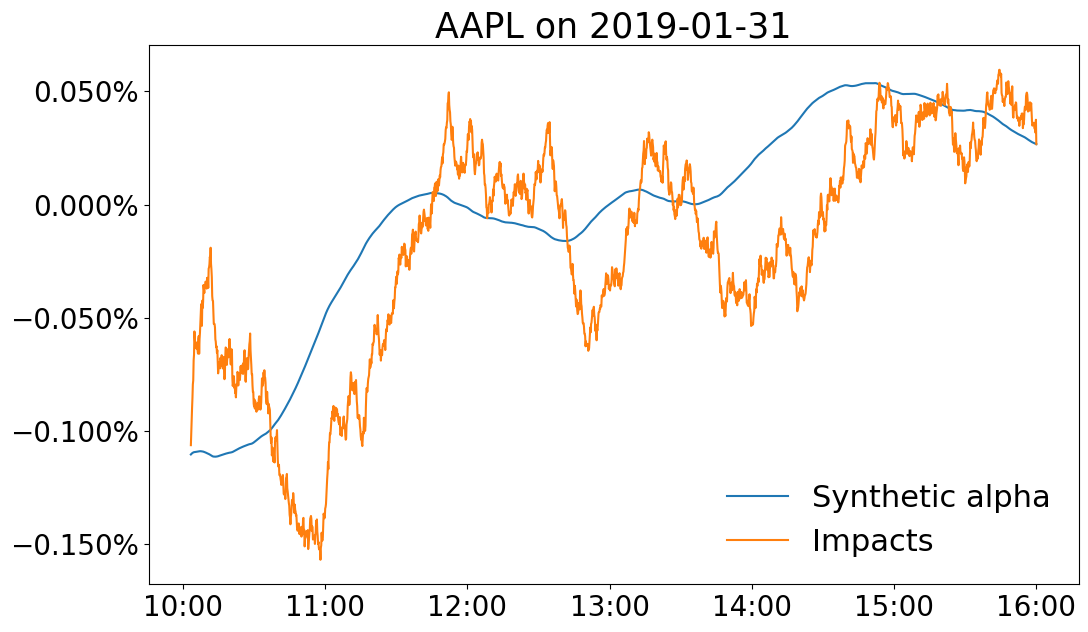

In [107]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)

ax.plot(pd.to_datetime(prices.T.index[202:]), smooth_synthetic_alphas_series.values[200:], label="Synthetic alpha")
ax.plot(pd.to_datetime(prices.T.index[202:]), intended_impacts.values[200:], label="Impacts")

ax.legend(fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title(f"{stock} on {date}", fontsize=25)

xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
ax.legend(fontsize=22, frameon=False)



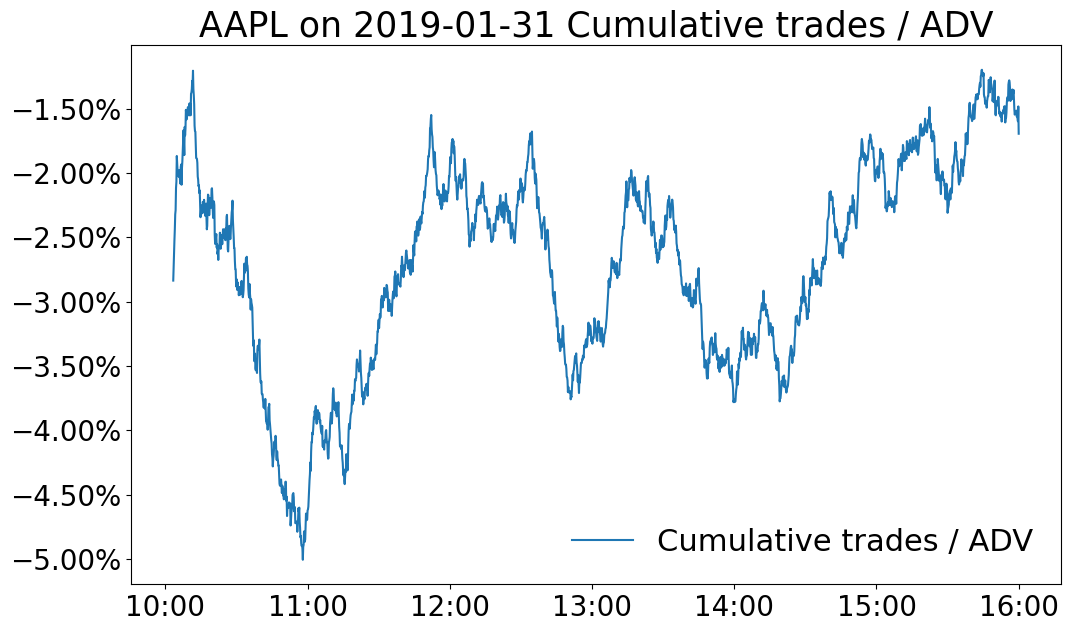

In [108]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)

ax.plot(pd.to_datetime(px_df2.T.index[202:]), pct_synthetic_alpha_optimal_trades.cumsum().values[200:], label="Cumulative trades / ADV")

ax.legend(fontsize=20)

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title(f"{stock} on {date} Cumulative trades / ADV", fontsize=25)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)

ax.legend(fontsize=22, frameon=False)


### 2.5 Optimal Trading Strategy

In [ ]:
def calculate_positions(alpha_df, threshold=0.00001):
    """
    Calculate trading positions based on the alpha signal.
    
    Parameters:
    alpha_df (pandas.DataFrame): DataFrame of synthetic alphas
    threshold (float): Threshold for determining trading positions
    
    Returns:
    pandas.DataFrame: DataFrame of trading positions (1 for long, -1 for short, 0 for no position)
    """
    positions = alpha_df.applymap(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))
    return positions

In [ ]:
def simulate_trading(positions_df, forward_returns_df):
    """
    Simulate trading strategy based on the trading positions and calculate cumulative returns. 
    Very simple. Assumes no price impact. Not the backtest engine.
    
    Parameters:
    positions_df (pandas.DataFrame): DataFrame of trading positions
    returns_df (pandas.DataFrame): DataFrame of forward returns
    
    Returns:
    pandas.Series: Series of cumulative returns
    """
    # Calculate daily returns based on positions
    daily_returns = positions_df * forward_returns_df
    
    # Calculate cumulative returns
    returns = daily_returns.sum(axis=1)  # Assume a constant exposure, hence we sum and not multiply
    
    return returns

In [ ]:
positions_df = calculate_positions(synthetic_alpha_df)

In [ ]:
stocks = set(stock_info_df["stock"])

returns = simulate_trading(positions_df, forward_return_df)
portfolio_returns = sum([returns[stock] for stock in stocks]) / len(stocks)  # Equal allocation to each stock

In [ ]:
returns["AAPL"].cumsum().plot(title="AAPL Returns")
plt.grid()

In [ ]:
portfolio_returns.cumsum().plot(title="Portfolio Returns")
plt.grid()

### 2.6 Performance Metrics

In [ ]:
def calculate_sharpe(returns, risk_free_rate=0):
    mean = returns.mean()
    std = returns.std()
    return (mean - risk_free_rate) / std

def bootstrap(data, samples):
    bootstrap_indices = np.random.choice(np.arange(len(data)), size=samples, replace=True)
    bootstrap_sample = data[bootstrap_indices]
    return bootstrap_sample

def bootstrap_confidence_interval(returns, risk_free_rate=0, alpha=0.05, samples=10**4):
    """
    Returns a 95% confidence interval on the sharpe
    """
    bootstrapped_sharpes = [calculate_sharpe(bootstrap(returns, samples), risk_free_rate=0) for i in range(samples)]
    bootstrapped_sharpes.sort()
    bootstrapped_sharpes = np.array(bootstrapped_sharpes)
    
    lower_index = alpha/2 * samples
    upper_index = samples - lower_index
    
    lower_index = round(lower_index)
    upper_index = round(upper_index)

    lower_bound = bootstrapped_sharpes[lower_index]
    upper_bound = bootstrapped_sharpes[upper_index]

    return (lower_bound, upper_bound, bootstrapped_sharpes)

def get_max_drawdown(returns):
    """
    Calculate the maximum drawdown for an array of returns.
    
    Parameters:
    returns (numpy.ndarray): Array of returns
    
    Returns:
    float: Maximum drawdown
    """
    # Calculate the cumulative returns
    cumulative_returns = returns.cumsum()
    
    # Calculate the running maximum of the cumulative returns
    running_max = np.maximum.accumulate(cumulative_returns)
    
    # Calculate the drawdown
    drawdown = cumulative_returns - running_max
    
    # Calculate the maximum drawdown
    max_drawdown = np.min(drawdown)
    
    return max_drawdown

def get_information(returns, risk_free_rate=0, alpha=0.05, samples=10**4):
    sharpe = calculate_sharpe(returns, risk_free_rate=risk_free_rate)
    lower_bound, upper_bound, bootstrapped_sharpes = bootstrap_confidence_interval(returns, risk_free_rate, alpha, samples)

    mean = returns.mean()

    max_drawdown = max(-get_max_drawdown(returns), 0)
    max_daily_drawdown = max(-min(returns), 0)

    print("Metrics")
    print("\n")
    print(f"Sharpe of: {sharpe}")
    print(f"With {(1-alpha)*100}% confidence interval: ({lower_bound}, {upper_bound})")
    print("\n")
    print(f"Expected Daily PnL: {100*mean}%")
    print("\n")
    print(f"Maximum Drawdown: {100*max_drawdown}%")
    print(f"Maximum Daily Drawdown: {100*max_daily_drawdown}%")
    
    plt.figure()
    plt.hist(bootstrapped_sharpes, density=True, bins=25)
    plt.xlabel("Sharpe")
    plt.ylabel("Density")
    plt.title("Distribution of Sharpe")
    plt.grid()
    plt.show()

In [ ]:
get_information(returns["AAPL"])

In [ ]:
get_information(portfolio_returns)

### 2.7 Sensitivity Analysis